In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
### Load Luke Mean ###

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [3]:
### Load JFRC2018 ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [4]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')
maps_voxel_res.shape

In [31]:
##################
### Unique GLM ###
##################

### Load supervoxel labels ###
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

### load glm ###
main_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210208_inst_uniq_glm/'
all_scores = []
for z in range(49):
    file = [os.path.join(main_dir, i) for i in os.listdir(main_dir) if f'Z{z}.' in i][0]
    with open(file, 'rb') as handle:
        scores = pickle.load(handle)
    all_scores.append(scores)
    
uniques = ['scores_ypos_unique', 'scores_zpos_unique', 'scores_zneg_unique']
maps = {}

for unique in uniques:
    all_colored_by_betas = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = all_scores[z]['scores_all'][cluster_num] - all_scores[z][unique][cluster_num]

            if len(cluster_indicies) > 100:
                colored_by_betas[cluster_indicies] = 0
            if colored_by_betas[cluster_indicies][0] == 1:
                colored_by_betas[cluster_indicies] = 0
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    maps[unique] = all_colored_by_betas
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['scores_zneg_unique'][z,:,:].T
    colors2 = maps['scores_zpos_unique'][z,:,:].T
    colors3 = maps['scores_ypos_unique'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)
func = np.swapaxes(slices, 0, 2)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')
maps_voxel_res.shape

(314, 146, 91, 3)

In [123]:
###################
### Supervoxels ###
###################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210101_correlation/"

n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
cluster_model_labels = np.load(labels_file)

behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    final_map = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]

#             if p_map[z,cluster_num] <= 5e-7:#1e-8 :
#                 sig = 1
#             else:
#                 sig = 0
            sig=1

            if len(cluster_indicies) > 100:
                sig = np.nan
            colored_by_betas[cluster_indicies] = r_map[z,cluster_num]*sig
        colored_by_betas = colored_by_betas.reshape(256,128)
        final_map.append(colored_by_betas)
    final_map = np.asarray(final_map)
    maps[behavior] = final_map

norm_min = 0
norm_max = np.max(np.nan_to_num(maps['Y_pos']))
norm_max = 1#0.15
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][z,:,:].T)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)

slices = np.asarray(slices)
func = np.swapaxes(slices, 0, 2)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')
maps_voxel_res.shape

(314, 146, 91, 3)

In [98]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20211209_red_correlation/"

n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
#labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'

cluster_model_labels = np.load(labels_file)

behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    final_map = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]

#             if p_map[z,cluster_num] <= 5e-7:#1e-8 :
#                 sig = 1
#             else:
#                 sig = 0
            sig = 1

            if len(cluster_indicies) > 100:
                sig = 0
            colored_by_betas[cluster_indicies] = r_map[z,cluster_num]*sig
        colored_by_betas = colored_by_betas.reshape(256,128)
        final_map.append(colored_by_betas)
    final_map = np.asarray(final_map)
    maps[behavior] = final_map
    
norm_min = 0
norm_max = np.max(np.nan_to_num(maps['Y_pos']))
norm_max = 1#0.15
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][z,:,:].T)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)

slices = np.asarray(slices)
func = np.swapaxes(slices, 0, 2)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')
maps_voxel_res.shape

(314, 146, 91, 3)

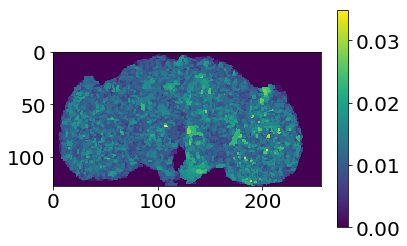

In [97]:
plt.imshow(np.max(np.nan_to_num(maps['Z_neg']),axis=0).T)

In [55]:
0.05/(2000*49)

5.102040816326531e-07

In [110]:
maps_voxel_res.shape

(314, 146, 91, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


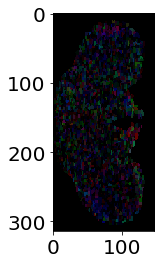

In [106]:
plt.imshow(maps_voxel_res[:,:,60,:]*20)

In [114]:
maps_voxel_res

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91, 3)
	 Spacing    : (2.0, 2.0, 2.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


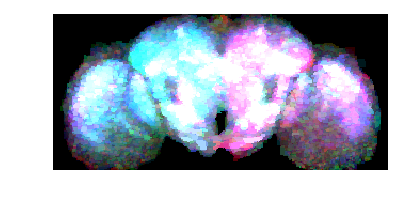

In [125]:
plt.imshow(np.swapaxes(np.max(np.nan_to_num(maps_voxel_res.numpy())*20,axis=2),0,1))
plt.axis('off')
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

# need to upsample to add ROI borders

In [ ]:
# started with 49 5.3um steps (259.7um)
# warped to 91 2um steps (182um)
# resampled to 363 steps (so now 0.5um steps giving 181.5um)

In [101]:
maps_voxel_high_res = ants.resample_image(maps_voxel_res,(1256, 584, 363, 3),use_voxels=True)
maps_voxel_high_res.shape

(1256, 584, 363, 3)

In [102]:
##################
### MAKE ALPHA ###
##################
signals = maps_voxel_high_res.numpy()
alpha = np.ones((1256, 584, 363))
alpha[np.where(np.sum(signals,axis=-1)==0)]=0 #correlation
alpha[np.where(np.sum(signals,axis=-1)<0.01)]=0 #unique glm

signals_alpha = np.concatenate((signals,alpha[..., np.newaxis]),axis=-1)

In [7]:
##########################
### Load High Res Anat ###
##########################

load_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210817_luke_mean_highres.nii"
anat_high_res = np.asarray(nib.load(load_file).get_data().squeeze(), dtype='float32')
anat_high_res.shape

(1256, 584, 363)

In [9]:
###########################
### Load High Res Atlas ###
###########################

atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed_nearest_neighbor.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
#atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)
atlas = ants.resample_image(atlas,(.5,.5,.5),use_voxels=False)
atlas = atlas.numpy()
atlas_int = atlas.astype('uint8')
atlas_int.shape

(1256, 584, 363)

# Plot

In [ ]:
# z is 363 steps, each 0.5um (181.5um total)

In [13]:
363*.76

275.88

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


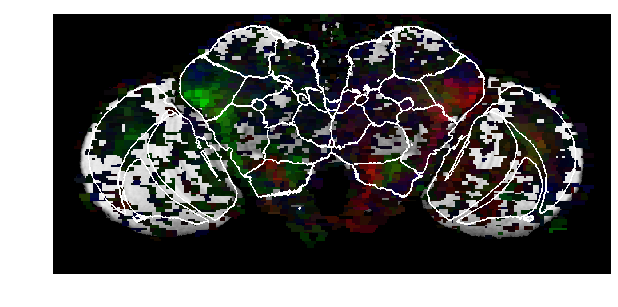

In [39]:
z=260
# get edges for this slice
edges = cv2.Canny(atlas_int[:,:,z],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.figure(figsize=(10,10))
plt.imshow(anat_high_res[:,:,z].T,cmap='gray')
plt.imshow(np.swapaxes(signals_alpha[:,:,z,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

plt.axis('off')
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/'
timestr = time.strftime("%Y%m%d-%H%M%S")
#label = format(z, '03d')
fname = os.path.join(save_path, f'{timestr}_z={z}')
plt.margins(0,0)
#plt.savefig(fname,dpi=100,bbox_inches='tight',pad_inches=0.0,transparent = True)

(0, 0.05)

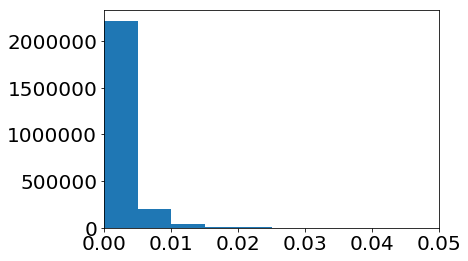

In [37]:
plt.hist(signals_alpha[:,:,z,:].flatten(),bins=200);
plt.xlim(0,.05)

In [27]:
#363 steps
363/49

7.408163265306122

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


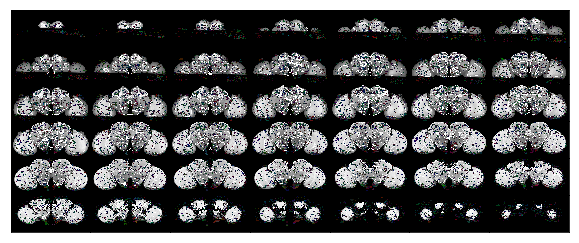

In [103]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 7), axes_pad=0)
step_size = 7
start_slice = 7*7

for i,ax in enumerate(grid):
    z = (step_size * i) + start_slice

    # get edges for this slice
    edges = cv2.Canny(atlas_int[:,:,z],1,1)
    edges = binary_dilation(edges, iterations=1)
    edges = scipy.ndimage.median_filter(edges,2)
    edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

    ax.imshow(anat_high_res[:,:,z].T,cmap='gray')
    ax.imshow(np.swapaxes(signals_alpha[:,:,z,:]*20,0,1)) # *20 for corr, *50 for glm
    ax.imshow(np.swapaxes(edges_,0,1)*10000)

    ax.set_xticks([])
    ax.set_yticks([])
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1255.5, 362.5, -0.5)

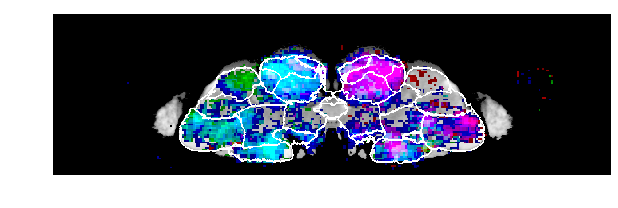

In [11]:
z=150
# get edges for this slice
edges = cv2.Canny(atlas_int[:,z,:],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.figure(figsize=(10,10))
plt.imshow(anat_high_res[:,z,:].T,cmap='gray')
plt.imshow(np.swapaxes(signals_alpha[:,z,:,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

plt.axis('off')
# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210817_corr_video'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# label = format(z, '03d')
# fname = os.path.join(save_path, f'{label}')
# plt.savefig(fname,dpi=100,bbox_inches='tight')


